## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

import pickle

## Import dataset and preprocessing

In [2]:
df = pd.read_csv('spam.csv',encoding="ISO-8859-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)

In [4]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.rename(columns={'v1' : 'CATEGORY','v2' : 'MSG'},inplace=True)

In [6]:
df.head()

,CATEGORY,MSG
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# convert CATEGORY column into one hot encoding
df['CATEGORY'] = pd.get_dummies(df.CATEGORY, drop_first=True)

In [8]:
df.head()

,CATEGORY,MSG
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### Check for null values

In [9]:
# check if any msg bodies are null
df['MSG'].isnull().values.any()

False

In [10]:
df.isnull().sum()

CATEGORY    0
MSG         0
dtype: int64

In [11]:
# check if there are empty msg
(df.MSG.str.len() == 0).any()

False

In [12]:
df.shape

(5572, 2)

## Text Pre-Processing

<ul>
    <li>Converting to lower case</li>
    <li>Tokenising</li>
    <li>Removing stop words</li>
    <li>Words stemming</li>
    <li>Removing punctuation</li>  
    <li>Stripping out html tags</li>
    
</ul>

### Download The NLTK Resources(Tokenizer and Stopwords)

In [13]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/programmer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/programmer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Function for cleaning the text

In [15]:
def clean_msg(msg, stemmer=PorterStemmer(), stop_words=set(stopwords.words('english'))):
    
    # remove html tags
    soup = BeautifulSoup(msg, 'html.parser')
    clean_text = soup.get_text()
    
    # convert to lower case and splits up the words
    words = word_tokenize(clean_text.lower())
    
    filter_words = []
    
    for word in words:
        # removing the stop words and punctuation 
        if word not in stop_words and word.isalpha():
            filter_words.append(stemmer.stem(word)) # words stemming
    
    return ' '.join(filter_words)

In [16]:
df.MSG = df.MSG.apply(clean_msg)

In [17]:
df.head()

,CATEGORY,MSG
0,0,go jurong point crazi avail bugi n great world...
1,0,ok lar joke wif u oni
2,1,free entri wkli comp win fa cup final tkt may ...
3,0,u dun say earli hor u c alreadi say
4,0,nah think goe usf live around though


### Tfidvectorizer

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfv = TfidfVectorizer(max_features=2500)
X = tfv.fit_transform(df.MSG).toarray()

In [19]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
y = df.CATEGORY

In [21]:
y

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: CATEGORY, Length: 5572, dtype: uint8

In [22]:
pickle.dump(tfv, open('CountVectorizer-transform.pkl', 'wb') )

### check whether dataset is imbalanced

In [23]:
df.CATEGORY.value_counts()

0    4825
1     747
Name: CATEGORY, dtype: int64

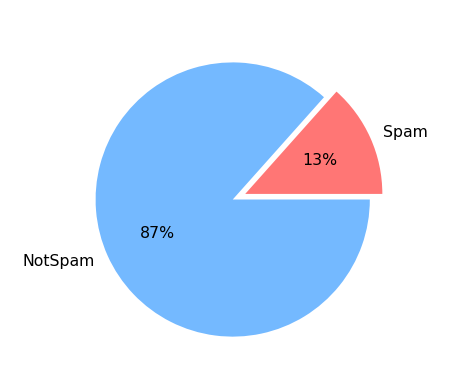

In [24]:
amount_ham = df.CATEGORY.value_counts()[0]
amount_spam = df.CATEGORY.value_counts()[1]

category_name = ['Spam', 'NotSpam']
sizes = [amount_spam ,amount_ham]
custom_color = ['#ff7675', '#74b9ff'] 


plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_name,textprops={'fontsize': 5},autopct='%1.0f%%',
                                colors = custom_color, explode = [0, 0.1])
plt.show()

In [25]:
X.shape

(5572, 2500)

In [27]:
from imblearn.over_sampling import RandomOverSampler

smote = RandomOverSampler(random_state=42)
X_sm, y_sm = smote.fit_resample(X, y)

In [28]:
y_sm.shape

(9650,)

In [29]:
y_sm.value_counts()

1    4825
0    4825
Name: CATEGORY, dtype: int64

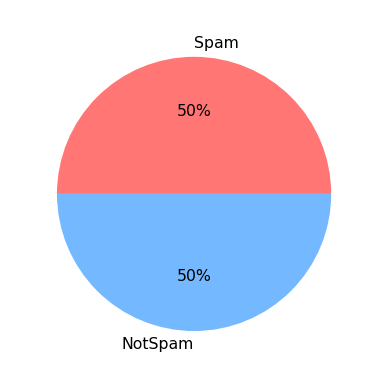

In [68]:
amount_ham = y_sm.value_counts()[0]
amount_spam = y_sm.value_counts()[1]
amount_ham
category_name = ['Spam', 'NotSpam']
sizes = [amount_spam ,amount_ham]
custom_color = ['#ff7675', '#74b9ff'] 


plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_name,textprops={'fontsize': 5},autopct='%1.0f%%',
                                colors = custom_color)
plt.show()

## Train test split

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.20, random_state=42)

## Train the model

In [31]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [32]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[939,  46],
       [ 30, 915]])

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       985
           1       0.95      0.97      0.96       945

    accuracy                           0.96      1930
   macro avg       0.96      0.96      0.96      1930
weighted avg       0.96      0.96      0.96      1930



### save the model

In [34]:
pickle.dump(model, open('spam-model.pkl', 'wb'))

### Testing examples

In [48]:
df.MSG[2900]

'ur current pound maxim ur send cash cc po box'

In [47]:
df.CATEGORY[2900]

1

In [51]:
print(df.MSG[2600])
df.CATEGORY[2600]

usual iam fine happi well


0